In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Path to data: /content/drive/MyDrive/Colab Notebooks/data/

Mounted at /content/drive


In [ ]:
# Needed for scipy.misc
!pip uninstall scipy
!pip install scipy==1.1.0 --user

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Import necessary items from Keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [ ]:
# Load training images
train_images = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/data/lane_detection_data/full_CNN_train.p", "rb" ))

# Load image labels
labels = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/data/lane_detection_data/full_CNN_labels.p", "rb" ))

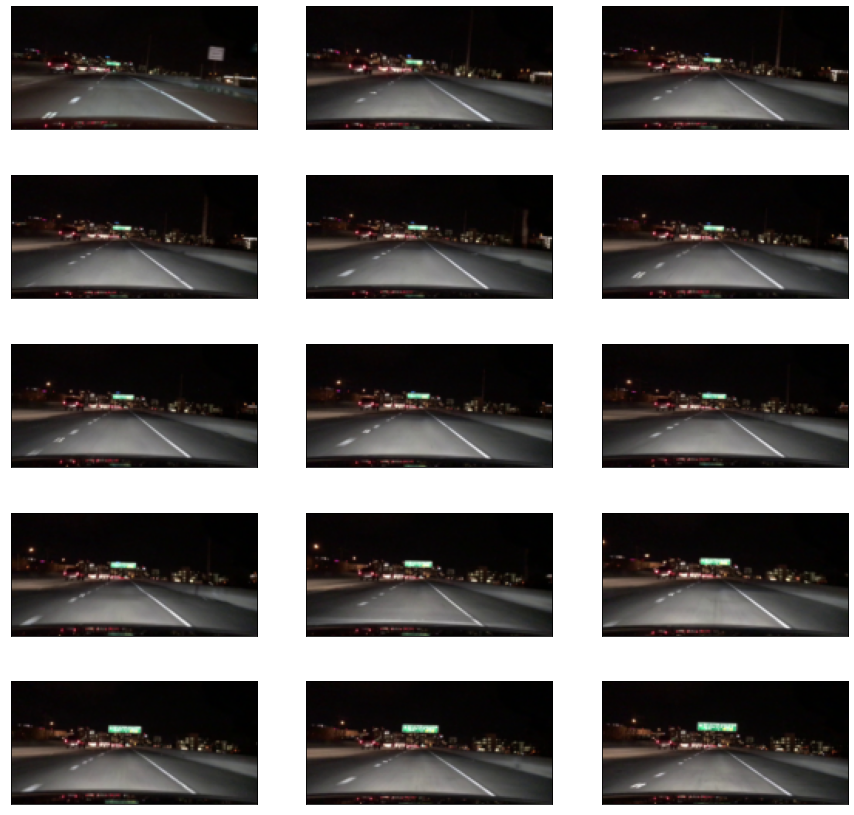

In [ ]:
#Some images of the data

plt.figure(figsize=(15,15))
for i in range(15):
    plt.subplot(5,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i], cmap=plt.cm.binary)
plt.show()

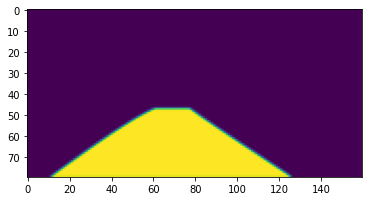

In [ ]:
# Labels
import tensorflow as tf
plt.imshow((tf.squeeze(labels[1])))

In [ ]:
# Make into arrays as the neural network wants these
train_images = np.array(train_images)
labels = np.array(labels)

# Normalize labels - training images get normalized to start in the network
labels = labels / 255

# Shuffle images along with their labels, then split into training/validation sets
train_images, labels = shuffle(train_images, labels)

# Test size 10%
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)

In [ ]:
# Batch size, epochs and pool size below are all paramaters to fiddle with for optimization
batch_size = 128
epochs = 10
pool_size = (2, 2)
input_shape = X_train.shape[1:]

In [ ]:
# Create the neural network
model = Sequential()
# Normalizes incoming inputs. First layer needs the input shape to work
model.add(BatchNormalization(input_shape=input_shape))

# Below layers were re-named for easier reading of model summary; this not necessary
# Conv Layer 1
model.add(Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv1'))

# Conv Layer 2
model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv2'))

# Pooling 1
model.add(MaxPooling2D(pool_size=pool_size))

# Conv Layer 3
model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv3'))
model.add(Dropout(0.2))

# Conv Layer 4
model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv4'))
model.add(Dropout(0.2))

# Conv Layer 5
model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv5'))
model.add(Dropout(0.2))

# Pooling 2
model.add(MaxPooling2D(pool_size=pool_size))

# Conv Layer 6
model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv6'))
model.add(Dropout(0.2))

# Conv Layer 7
model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Conv7'))
model.add(Dropout(0.2))

# Pooling 3
model.add(MaxPooling2D(pool_size=pool_size))

# Upsample 1 : Used to increases resolution, improves anti-aliasing filter performance and reduces noise
model.add(UpSampling2D(size=pool_size))

# Deconv 1
model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv1'))
model.add(Dropout(0.2))

# Deconv 2
model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv2'))
model.add(Dropout(0.2))

# Upsample 2
model.add(UpSampling2D(size=pool_size))

# Deconv 3
model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv3'))
model.add(Dropout(0.2))

# Deconv 4
model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv4'))
model.add(Dropout(0.2))

# Deconv 5
model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv5'))
model.add(Dropout(0.2))

# Upsample 3
model.add(UpSampling2D(size=pool_size))

# Deconv 6
model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Deconv6'))

# Final layer - only including one channel so 1 filter
model.add(Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'relu', name = 'Final'))

In [ ]:
# Model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 80, 160, 3)        12        
_________________________________________________________________
Conv1 (Conv2D)               (None, 78, 158, 8)        224       
_________________________________________________________________
Conv2 (Conv2D)               (None, 76, 156, 16)       1168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 78, 16)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 36, 76, 16)        2320      
_________________________________________________________________
dropout (Dropout)            (None, 36, 76, 16)        0         
_________________________________________________________________
Conv4 (Conv2D)               (None, 34, 74, 32)        4

In [ ]:
# Using a data generator to help the model use less data and avoid overfitting
# Channel shifts help with shadows slightly
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)

In [ ]:
# Compiling and training the model
model.compile(optimizer='Adam', 
              loss='mean_squared_error',
              metrics=['accuracy'])

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=len(X_train)/batch_size,
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(X_val, y_val))

Epoch 1/10
89/89 [==============================] - 24s 168ms/step - loss: 0.0847 - accuracy: 0.8732 - val_loss: 0.0297 - val_accuracy: 0.9470
Epoch 2/10
89/89 [==============================] - 13s 145ms/step - loss: 0.0182 - accuracy: 0.9507 - val_loss: 0.0131 - val_accuracy: 0.9545
Epoch 3/10
89/89 [==============================] - 13s 147ms/step - loss: 0.0131 - accuracy: 0.9541 - val_loss: 0.0119 - val_accuracy: 0.9555
Epoch 4/10
89/89 [==============================] - 14s 150ms/step - loss: 0.0111 - accuracy: 0.9554 - val_loss: 0.0103 - val_accuracy: 0.9566
Epoch 5/10
89/89 [==============================] - 13s 149ms/step - loss: 0.0099 - accuracy: 0.9563 - val_loss: 0.0085 - val_accuracy: 0.9572
Epoch 6/10
89/89 [==============================] - 13s 147ms/step - loss: 0.0091 - accuracy: 0.9569 - val_loss: 0.0078 - val_accuracy: 0.9578
Epoch 7/10
89/89 [==============================] - 13s 146ms/step - loss: 0.0085 - accuracy: 0.9573 - val_loss: 0.0078 - val_accuracy: 0.9577

In [ ]:
# Save model architecture and weights
model.save('/content/drive/MyDrive/Colab Notebooks/data/lane_detection_data/CNN_model2.h5')

In [ ]:
from scipy.misc import imresize
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from keras.models import load_model


# Class to average lanes with
class Lanes():
    def __init__(self):
        self.recent_fit = []
        self.avg_fit = []


def road_lines(image):
    """ Takes in a road image, re-sizes for the model,
    predicts the lane to be drawn from the model in G color,
    recreates an RGB image of a lane and merges with the
    original road image.
    """

    # Get image ready for feeding into model
    small_img = imresize(image, (80, 160, 3))
    small_img = np.array(small_img)
    small_img = small_img[None,:,:,:]

    # Make prediction with neural network (un-normalize value by multiplying by 255)
    prediction = model.predict(small_img)[0] * 255

    # Add lane prediction to list for averaging
    lanes.recent_fit.append(prediction)
    # Only using last five for average
    if len(lanes.recent_fit) > 5:
        lanes.recent_fit = lanes.recent_fit[1:]

    # Calculate average detection
    lanes.avg_fit = np.mean(np.array([i for i in lanes.recent_fit]), axis = 0)

    # Generate fake R & B color dimensions, stack with G
    blanks = np.zeros_like(lanes.avg_fit).astype(np.uint8)
    lane_drawn = np.dstack((blanks, lanes.avg_fit, blanks))

    # Re-size to match the original image
    lane_image = imresize(lane_drawn, (720, 1280, 3))

    # Merge the lane drawing onto the original image
    result = cv2.addWeighted(image, 1, lane_image, 1, 0)

    return result

In [ ]:
# Load the model
model = load_model('/content/drive/MyDrive/Colab Notebooks/data/lane_detection_data/CNN_model2.h5')

# Create lanes object
lanes = Lanes()

# Where to save the output video
vid_output = '/content/drive/MyDrive/Colab Notebooks/data/lane_detection_data/output_v2_2.mp4'

# Location of the input video
clip = VideoFileClip("/content/drive/MyDrive/Colab Notebooks/data/lane_detection_data/test_video1.mp4")

# Create the clip
vid_clip = clip.fl_image(road_lines)
vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video /content/drive/MyDrive/Colab Notebooks/data/lane_detection_data/output_v2_2.mp4
[MoviePy] Writing video /content/drive/MyDrive/Colab Notebooks/data/lane_detection_data/output_v2_2.mp4


100%|█████████▉| 1260/1261 [02:07<00:00,  9.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/MyDrive/Colab Notebooks/data/lane_detection_data/output_v2_2.mp4 

